In [1]:
import datetime
import logging
import os
import time
from pathlib import Path
from threading import Event, Thread
from typing import Optional

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import torch
import torch.nn as nn
from datasets import load_dataset
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import v2 as T_v2
from tqdm import tqdm
from transformers import AutoImageProcessor, AutoModel, PreTrainedModel, set_seed

In [2]:
# TASK
TASK_NAME = "dinov2_imagenet"
SEED = 47

# MONITOR
MAIN_PID = os.getpid()
MONITOR_INTERVAL = 0.1
USAGE_INFO = []
CPU_PERCENT_HISTORY = []

cnt_cpu = psutil.cpu_count(logical=True)
assert cnt_cpu is not None
NUM_CPUS = int(cnt_cpu)

# MODEL
MODEL_PATH = "./model/dinov2_small"
DATASET_PATH = "./dataset/imagenet1k"
MODEL_DIM = 384
NUM_CLASS = 1000
BATCH_SIZE = 1024
LEARNING_RATE = 1e-3
NUM_EPOCHS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = 4

# Tensorboard
LOG_DIR = f"./runs/{TASK_NAME}_" + datetime.datetime.now().strftime("%m%d%H%M%S")


In [3]:
# Logger
formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s)")

file_handler = logging.FileHandler(f"{TASK_NAME}.log", encoding="utf-8")
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter)

stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.INFO)
stream_handler.setFormatter(formatter)

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(file_handler)
logger.addHandler(stream_handler)

In [4]:
# Monitor
def get_process_group_usage(pid: int):
    total_mem = 0
    total_proc_cnt = 0
    all_cpu_affinity = set()

    try:
        main_proc = psutil.Process(pid)
        all_proc = [main_proc] + main_proc.children(recursive=True)
        total_proc_cnt = len(all_proc)

        for p in all_proc:
            try:
                if p.is_running():
                    cpu_affinity = p.cpu_affinity()
                    if cpu_affinity is not None:
                        all_cpu_affinity.update(cpu_affinity)
                total_mem += p.memory_info().rss
            except psutil.NoSuchProcess:
                continue

    except Exception as e:
        logger.error(f"Get Process Info Failed: {e}", exc_info=True)

    return {
        "memory_gb": total_mem / (1024**3),
        "process_count": total_proc_cnt,
        "affinity_cores": sorted(list(all_cpu_affinity)),
    }


def monitor_usage(interval_sec: float, stop_event: Event):
    try:
        # Priming
        psutil.Process(MAIN_PID).cpu_percent()
        psutil.cpu_percent(percpu=True)
        time.sleep(0.1)
    except psutil.NoSuchProcess:
        logger.error("Process Not Found", exc_info=True)
        return

    while not stop_event.is_set():
        cur_time = time.time()
        usage_data = get_process_group_usage(MAIN_PID)
        cpu_percent = psutil.cpu_percent(percpu=True)

        USAGE_INFO.append({"time": cur_time, **usage_data})
        CPU_PERCENT_HISTORY.append(cpu_percent)

        time.sleep(interval_sec)


def get_vm_total_memory():
    mem_info = psutil.virtual_memory()
    total_gb = mem_info.total / (1024**3)
    return total_gb


ALLOC_MEM = get_vm_total_memory()

In [5]:
# Init
def set_all_seeds(seed: int):
    set_seed(seed)
    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True


set_all_seeds(SEED)
tb_writer = SummaryWriter(LOG_DIR)

# Start Monitor
stop_monitor_event = Event()
monitor_thread = Thread(target=monitor_usage, args=(MONITOR_INTERVAL, stop_monitor_event))
monitor_thread.start()

In [6]:
# Dataset
class MiniImageNetDataset(Dataset):
    def __init__(self, root_dir: str, split: str, transform: Optional[T_v2.Compose] = None):
        self.root_dir = Path(root_dir) / split
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_idx = {}

        for i, class_path in enumerate(sorted(self.root_dir.iterdir())):
            if class_path.is_dir():
                class_name = class_path.name
                self.class_idx[class_name] = i
                image_files = list(class_path.glob("*.JPEG"))
                for img_path in image_files:
                    self.labels.append(i)
                    self.image_paths.append(img_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        image = Image.open(str(img_path)).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return {"image": image, "label": label}


class ImageNetDataset(Dataset):
    def __init__(self, root_dir: str, split: str, transform: Optional[T_v2.Compose] = None):
        self.dataset = load_dataset("parquet", data_dir=root_dir, split=split)
        self.transform = transform
        self.class_idx = {label: idx for idx, label in enumerate(self.dataset.features["label"].names)}

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        label = torch.tensor(item["label"], dtype=torch.long)

        image = item["image"].convert("RGB")

        if self.transform:
            image = self.transform(image)

        return {"image": image, "label": label}


def get_train_transforms():
    transforms_list = [
        # RandomFlip
        T_v2.RandomHorizontalFlip(p=0.5),
        T_v2.RandomVerticalFlip(p=0.0),
        # random_rotate
        T_v2.RandomChoice(
            [
                T_v2.RandomRotation([0, 0]),
                T_v2.RandomRotation([90, 90]),
                T_v2.RandomRotation([180, 180]),
                T_v2.RandomRotation([270, 270]),
            ]
        ),
    ]

    return T_v2.Compose(transforms_list)


class ImageCollate:
    def __init__(self, processor: AutoImageProcessor):
        self.processor = processor

    def __call__(self, batch: list[dict]):
        images = [item["image"] for item in batch]
        labels = [item["label"] for item in batch]

        encoding = self.processor(images, return_tensors="pt")  # type: ignore

        batch_labels = torch.stack(labels)

        result_batch = {
            "pixel_values": encoding["pixel_values"],
            "labels": batch_labels,
        }

        return result_batch


In [7]:
# Create Model Backbone
processor = AutoImageProcessor.from_pretrained(MODEL_PATH)
model_backbone = AutoModel.from_pretrained(MODEL_PATH)

# Create Dataset
# train_dataset = MiniImageNetDataset(DATASET_PATH, split="train", transform=get_train_transforms())
# val_dataset = MiniImageNetDataset(DATASET_PATH, split="test")
train_dataset = ImageNetDataset(DATASET_PATH, split="train", transform=get_train_transforms())
val_dataset = ImageNetDataset(DATASET_PATH, split="validation")

# Create DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=ImageCollate(processor),
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=ImageCollate(processor),
)

logger.info(f"Training Data: {len(train_dataset):>7d} ({len(train_dataset.class_idx):>4d} class)")
logger.info(f" Testing Data: {len(val_dataset):>7d} ({len(val_dataset.class_idx):>4d} class)")
logger.info(f"       Resize: {processor.size}")
logger.info(f"    Crop_size: {processor.crop_size}")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
2025-11-18 02:09:49,673 - INFO - Training Data:   50000 (1000 class))
2025-11-18 02:09:49,673 - INFO -  Testing Data:   50000 (1000 class))
2025-11-18 02:09:49,674 - INFO -        Resize: {'shortest_edge': 256})
2025-11-18 02:09:49,674 - INFO -     Crop_size: {'height': 224, 'width': 224})


In [ ]:
# Model
HIDDEN_DIM = 768
DROPOUT_RATE = 0.1


class DINOv2LinearClassifier(nn.Module):
    def __init__(
        self,
        dinov2_model: PreTrainedModel,
        embed_dim: int,
        num_classes: int,
        hidden_dim: int = HIDDEN_DIM,
        dropout_rate: float = DROPOUT_RATE,
    ):
        super().__init__()
        self.dinov2 = dinov2_model
        for param in self.dinov2.parameters():
            param.requires_grad = False

        self.mlp_1 = nn.Linear(embed_dim, hidden_dim)
        self.activation = nn.GELU()
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, pixel_values: torch.Tensor):
        outputs = self.dinov2(pixel_values, output_hidden_states=False)
        cls_token_output = outputs.last_hidden_state[:, 0, :]
        x = self.mlp_1(cls_token_output)
        x = self.activation(x)

        x = self.dropout(x)
        logits = self.classifier(x)
        return logits

In [9]:
# Create Model
model = DINOv2LinearClassifier(model_backbone, MODEL_DIM, NUM_CLASS)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

In [10]:
# Train
def train_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.modules.loss._Loss,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    epoch: int,
    step: int,
):
    model.train()
    total_loss = 0
    num_correct = 0
    num_data = 0

    for batch in tqdm(dataloader, desc="TRAIN"):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()

        logits = model(pixel_values)
        loss = criterion(logits, labels)
        loss.backward()
        total_loss += loss.item()

        optimizer.step()

        _, predicted = torch.max(logits.data, 1)
        correct = (predicted == labels).sum()
        num_correct += correct.item()
        step_acc = correct / labels.size(0)

        tb_writer.add_scalar("Train/step_loss", loss.item(), step)
        tb_writer.add_scalar("Train/step_accuracy", step_acc, step)

        num_data += labels.size(0)
        step += 1

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * num_correct / num_data
    tb_writer.add_scalar("Train/loss", avg_loss, epoch)
    tb_writer.add_scalar("Train/accuracy", accuracy, epoch)
    return avg_loss, accuracy


# Test
def evaluate(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.modules.loss._Loss,
    device: torch.device,
    epoch: int,
):
    model.eval()
    total_loss = 0
    num_correct = 0
    num_data = 0
    st = time.time()

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="TEST"):
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            logits = model(pixel_values)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            _, predicted = torch.max(logits.data, 1)
            num_data += labels.size(0)
            num_correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * num_correct / num_data
    elapsed_time = time.time() - st

    tb_writer.add_scalar("Test/loss", avg_loss, epoch)
    tb_writer.add_scalar("Test/accuracy", accuracy, epoch)
    tb_writer.add_scalar("Test/time", elapsed_time, epoch)
    return avg_loss, accuracy, elapsed_time

In [11]:
lst_time = []
step = 0
model.to(DEVICE)

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE, epoch, step)
    val_loss, val_acc, elapsed_time = evaluate(model, val_loader, criterion, DEVICE, epoch)
    lst_time.append(elapsed_time)

    logger.info(
        f"[{epoch:>3d}/{NUM_EPOCHS:>3d}] - Train Acc: {train_acc:.2f}%, Train Loss: {train_loss:.2f}, Test Acc: {val_acc:.2f}%, Test Loss: {val_loss:.2f}"
    )

stop_monitor_event.set()
logger.info(f"Inference Average Cost Time: {sum(lst_time) / len(lst_time):.2f} sec")

TEST: 100%|██████████| 49/49 [00:50<00:00,  1.03s/it]
2025-11-18 02:11:34,282 - INFO - [  0/  5] - Train Acc: 29.35%, Train Loss: 4.21, Test Acc: 65.73%, Test Loss: 1.60)
TEST: 100%|██████████| 49/49 [00:50<00:00,  1.03s/it]
2025-11-18 02:13:21,115 - INFO - [  1/  5] - Train Acc: 63.66%, Train Loss: 1.57, Test Acc: 76.45%, Test Loss: 0.97)
TEST: 100%|██████████| 49/49 [00:51<00:00,  1.04s/it]
2025-11-18 02:15:08,321 - INFO - [  2/  5] - Train Acc: 71.19%, Train Loss: 1.18, Test Acc: 80.86%, Test Loss: 0.77)
TEST: 100%|██████████| 49/49 [00:49<00:00,  1.01s/it]
2025-11-18 02:16:54,733 - INFO - [  3/  5] - Train Acc: 75.59%, Train Loss: 0.99, Test Acc: 83.54%, Test Loss: 0.65)
TEST: 100%|██████████| 49/49 [00:49<00:00,  1.01s/it]
2025-11-18 02:18:40,189 - INFO - [  4/  5] - Train Acc: 78.51%, Train Loss: 0.86, Test Acc: 85.63%, Test Loss: 0.56)
2025-11-18 02:18:40,190 - INFO - Inference Average Cost Time: 50.27 sec)


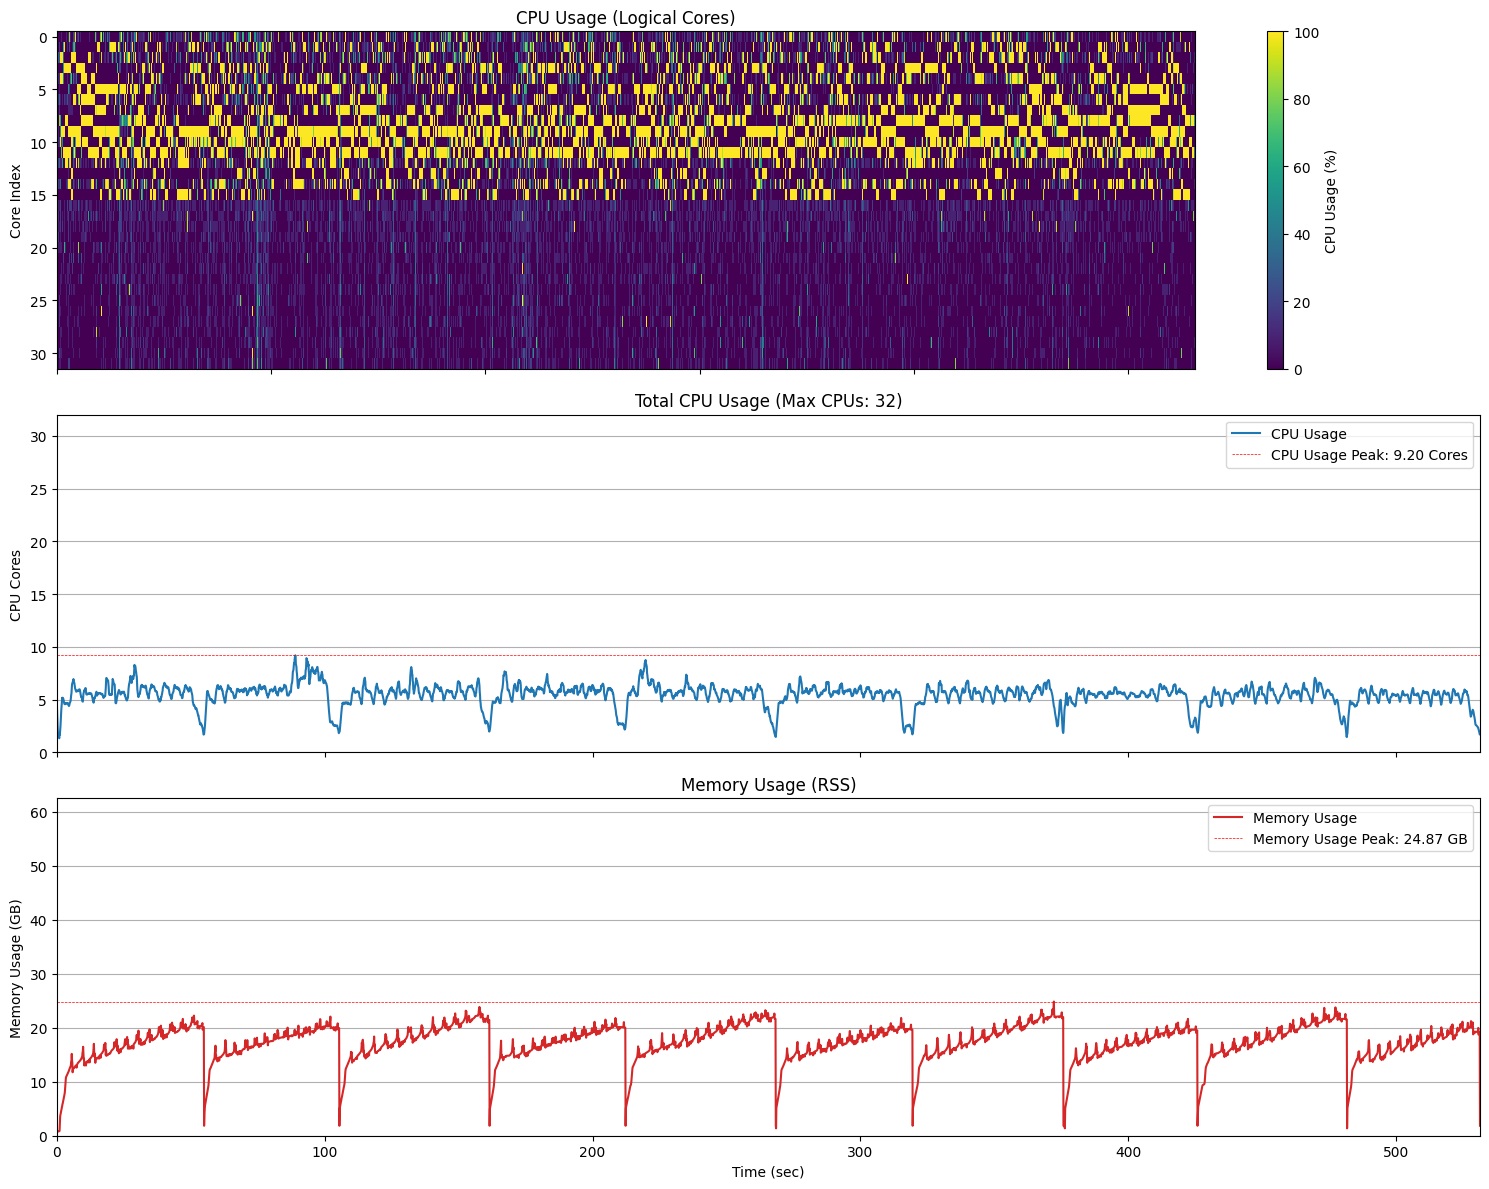

In [12]:
def moving_average_forward(data_list, window_size=9):
    N = len(data_list)
    new_list = []

    for i in range(N):
        start_index = max(0, i - window_size)
        window = data_list[start_index : i + 1]
        average = sum(window) / len(window) if window else 0
        new_list.append(average)

    return new_list


if USAGE_INFO:
    df = pd.DataFrame.from_records(USAGE_INFO)
    ELAPSED_TIME = df["time"] - df["time"].min()
    MEM_USAGE = df["memory_gb"]
    cpu_matrix = np.array(CPU_PERCENT_HISTORY)

    cpu_usage = []
    for i in cpu_matrix:
        result = [v for v in i if v > 0.5]
        cpu_usage.append(sum(result) / 100)

    cpu_usage = moving_average_forward(cpu_usage)

    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(15, 12))
    ax1, ax2, ax3 = axes

    # CPU Heapmap
    im = ax1.imshow(
        cpu_matrix.T,
        aspect="auto",
        interpolation="none",
        norm=mcolors.Normalize(vmin=0, vmax=100),
        extent=[ELAPSED_TIME.min(), ELAPSED_TIME.max(), NUM_CPUS - 0.5, -0.5],
    )
    ax1.set_title("CPU Usage (Logical Cores)")
    ax1.set_ylabel("Core Index")
    fig.colorbar(im, ax=ax1, orientation="vertical", label="CPU Usage (%)")

    # CPU Usage
    ax2.plot(ELAPSED_TIME, cpu_usage, label="CPU Usage", color="tab:blue")
    ax2.axhline(
        max(cpu_usage),
        color="r",
        linestyle="--",
        linewidth=0.5,
        label=f"CPU Usage Peak: {max(cpu_usage):.2f} Cores",
    )
    ax2.set_title(f"Total CPU Usage (Max CPUs: {NUM_CPUS})")
    ax2.set_ylabel("CPU Cores")
    ax2.set_ylim(0, NUM_CPUS)
    ax2.legend(loc="upper right")
    ax2.grid(True, axis="y")

    # Memory Usage
    ax3.plot(ELAPSED_TIME, MEM_USAGE, label="Memory Usage", color="tab:red")
    ax3.axhline(
        max(MEM_USAGE),
        color="r",
        linestyle="--",
        linewidth=0.5,
        label=f"Memory Usage Peak: {max(MEM_USAGE):.2f} GB",
    )
    ax3.set_title("Memory Usage (RSS)")
    ax3.set_xlabel("Time (sec)")
    ax3.set_ylabel("Memory Usage (GB)")
    ax3.set_ylim(0, ALLOC_MEM)
    ax3.legend(loc="upper right")
    ax3.grid(True, axis="y")

    plt.tight_layout()
    plt.show()

In [13]:
PATH = "model_weights.pth"
torch.save(model, PATH)
model2 = torch.load("model_weights.pth", weights_only=False)

for k, v in model2.state_dict().items():
    print(f"{k:>25s}: {v.size()}")

dinov2.embeddings.cls_token: torch.Size([1, 1, 384])
dinov2.embeddings.mask_token: torch.Size([1, 384])
dinov2.embeddings.position_embeddings: torch.Size([1, 1370, 384])
dinov2.embeddings.patch_embeddings.projection.weight: torch.Size([384, 3, 14, 14])
dinov2.embeddings.patch_embeddings.projection.bias: torch.Size([384])
dinov2.encoder.layer.0.norm1.weight: torch.Size([384])
dinov2.encoder.layer.0.norm1.bias: torch.Size([384])
dinov2.encoder.layer.0.attention.attention.query.weight: torch.Size([384, 384])
dinov2.encoder.layer.0.attention.attention.query.bias: torch.Size([384])
dinov2.encoder.layer.0.attention.attention.key.weight: torch.Size([384, 384])
dinov2.encoder.layer.0.attention.attention.key.bias: torch.Size([384])
dinov2.encoder.layer.0.attention.attention.value.weight: torch.Size([384, 384])
dinov2.encoder.layer.0.attention.attention.value.bias: torch.Size([384])
dinov2.encoder.layer.0.attention.output.dense.weight: torch.Size([384, 384])
dinov2.encoder.layer.0.attention.outp